In [1]:
#Importing essentials
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import seaborn as sns
import math as math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
from mpl_toolkits import mplot3d
from sklearn import preprocessing

from scipy.integrate import quad

#Graph Settings
fig_size = plt.rcParams["figure.figsize"]
# Prints: [8.0, 6.0]
#print ("Current size:", fig_size)
# Set figure width to 12 and height to 9
fig_size[0] = 20
fig_size[1] =15
plt.rcParams["figure.figsize"] = fig_size

name=["SKMS", "SKP","SLY4","SV-MIN","UNEDF0","UNEDF1",]

df = pd.read_csv('dme_LO.csv')


Import Data

In [2]:
exp_energies = pd.read_csv('EXPERIMENT_AME2016_headers.dat', sep='\s+')
exp_energies = exp_energies.rename(columns={'Z': 'proton_number', 'N': 'neutron_number', \
                                             'E': 'exp_energy', \
                                             'E/A': 'exp_energy_per_nucleons'})
theory = pd.read_csv('ground_states_une0_quartz_intel_mkl-omp.csv')


Finding where theory and experimental match adding difference between experimental and theoretical

In [3]:
def intersect(chart1, chart2):
    return pd.merge(chart1, chart2, how='inner', on=['proton_number', 'neutron_number'])


exp_match = intersect(exp_energies, theory)
#exp_match['energy']
#exp_match['exp_energy']
exp_match_diff=exp_match['energy']-exp_match['exp_energy']
exp_match_diff

exp_match['exp_theory_diff']=exp_match_diff

Finding where there is only theory values

In [4]:
theory_only = theory[pd.merge(theory, exp_match, on=['proton_number','neutron_number'], how='left', indicator=True)['_merge'] == 'left_only']

separating the matching data set so that the random forest can be evaluated while still having experimental nuclei to test again in the neutron rich region

In [5]:
reduced_match=pd.DataFrame
test_match=pd.DataFrame

r_m=[]
t_m=[]
test_match_width=3
for p_n in range(2,118):
    sub_df=exp_match.loc[exp_match["proton_number"]==p_n]
    len_sub=len(sub_df)
    sub_sub_df=sub_df.iloc[0:len_sub-test_match_width]
    sub_sub_sub_df=sub_df.iloc[len_sub-test_match_width:len_sub]
    
    
    r_m.append(sub_sub_df)
    t_m.append(sub_sub_sub_df)

reduced_match=pd.concat(r_m)
test_match=pd.concat(t_m)


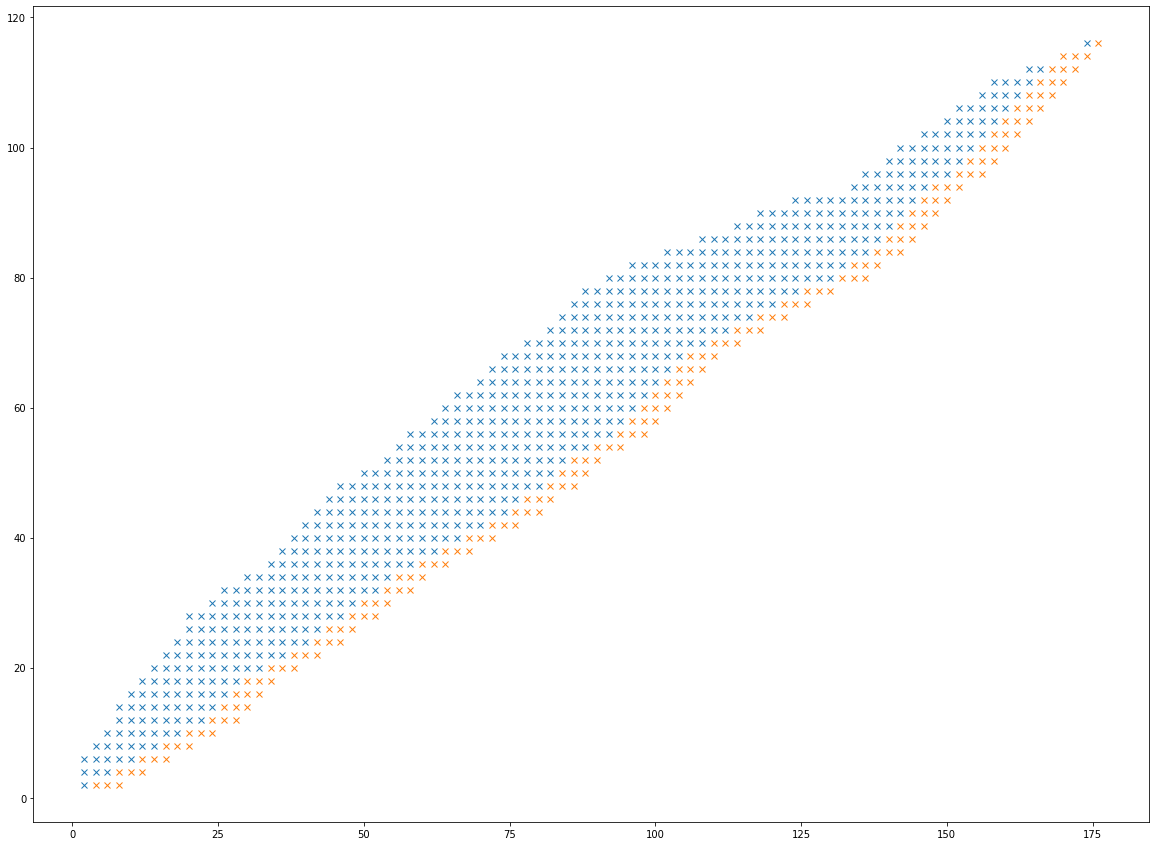

In [6]:
plt.plot(reduced_match['neutron_number'],reduced_match['proton_number'], 'x')
plt.plot(test_match['neutron_number'],test_match['proton_number'], 'x')
plt.show()

In [7]:
def make_and_fit_rf(X_train,y_train):
    rf = RandomForestRegressor(n_estimators= 1000, random_state=42)
    rf.fit(X_train,y_train)
    
    return rf

def making_rf_predictions_for_match(train_test_set, target_set):
    X_train, X_test, y_train, y_test = train_test_split(train_test_set,target_set, test_size = 0.05, random_state=42 )
    
    
    rf = make_and_fit_rf(X_train,y_train) 
    
    print("feature importance:  ", rf.feature_importances_)
    print("train score:  ", rf.score(X_train,y_train))
    print("test score:   ", rf.score(X_test,y_test))
    
    train_pred = rf.predict(X_train)
    test_pred  = rf.predict(X_test)
    
    predictions= rf.predict(train_test_set)
    
    a= mean_squared_error(train_pred, y_train)
    b= mean_squared_error(test_pred, y_test)
    c= mean_squared_error(predictions, target_set)
    
    print("train error:  ", a)
    print("test error:   ", b)
    print("all error:    ", c)
    
    return rf,predictions

def getting_feature_importance(training_set,target_set):
    rf = make_and_fit_rf(training_set,target_set)
    print("feature importance:  ", rf.feature_importances_)
    print("score importance:  ", rf.score(training_set,target_set))
    

def making_rf_predictions_for_theory(rf, vals):
    
    return rf.predict(vals)

def using_reduced_and_test_match(reduced_set, test_set, r_target_set, t_target_set):

    #X_train, X_test, y_train, y_test = train_test_split(reduced_set,r_target_set, test_size = 0.05, random_state=42 )
    rf = make_and_fit_rf(reduced_set,r_target_set) 
    
    #print("reduced train score:  ", rf.score(X_train,y_train))
    #print("reduced test score:   ", rf.score(X_test,y_test))
    #print("reduced set score: ", rf.score(reduced_set,r_target_set), '\n')
    
    #print("test set score: ", rf.score(test_set,t_target_set))
    a=rf.score(test_set,t_target_set)
    b=rf.score(reduced_set,r_target_set)
    
    r_t_diff=a-b#rf.score(test_set,t_target_set)-rf.score(reduced_set,r_target_set)
    
    print("feature importance:  ", rf.feature_importances_)
        

    print('test score reduction', r_t_diff)
    
    print('reduced_set_score: ', b)
    print('test_set_score: ', a)
    
    #reduced_train_pred = rf.predict(X_train)
    #reduced_test_pred  = rf.predict(X_test)
    reduced_predictions= rf.predict(reduced_set)
    test_predictions   = rf.predict(test_set)
    
    
    #a= mean_squared_error(reduced_train_pred, y_train)
    #b= mean_squared_error(reduced_test_pred, y_test)
    #c= mean_squared_error(reduced_predictions, r_target_set)
    #d= mean_squared_error(test_predictions, t_target_set)
    
    #print("train error:  ", a)
    #print("test error:   ", b)
    #print("reduced error:    ", c)
    #print("test error:    ", d)
    
    return rf, reduced_predictions, test_predictions
    
    
    

In [8]:
a=['proton_number', 'quadrupole-moment_p', 'spin-orbit-energy','beta2-deformation_p']


#make predictions with rf trained on the whole mach set
#obtain the score, error, predictions for match nuclei and non mach nuclei 
#print: score, error for train test and all
#return: predictions for match and non match and rf


#make predictions with rf trained on the reduced mach set
#print: score and error for both reduced and test
#return: predictions for mach and non match

#Data sets available:
#exp_match
#theory_only
#reduced_match
#test_match

#y_reduced = reduced_match['exp_theory_diff']

def making_set_from_all(a):
    sub_a=[]
    for i in a:
        print(i)
        sub_a.append(exp_match[i])
        
    print(np.shape(np.transpose(sub_a)))
    
    return np.transpose(sub_a)


def making_set_from_reduced_and_test(a):
    sub_a=[]
    for i in a:
        print(i)
        sub_a.append(reduced_match[i])
        
    print(np.shape(np.transpose(sub_a)))
    
    sub_b=[]
    for i in b:
        print(i)
        sub_b.append(test_match[i])
        
    print(np.shape(np.transpose(sub_b)))
    
    return np.transpose(sub_a), np.transpose(sub_b)
        
    
    

# SPACE
# SPACE
# SPACE
# SPACE
# SPACE
# SPACE
# SPACE
# SPACE
# SPACE
# SPACE
# SPACE
# SPACE
# SPACE
# SPACE
# SPACE

#Features Being Evaluated:

proton_number
neutron_number
feature importance:   [0.67782055 0.32217945]
all error:     0.2473705803690913

proton_number
quadrupole-moment_p
spin-orbit-energy
beta2-deformation_p
feature importance:   [0.49015982 0.08219238 0.22957747 0.19807033]
all error:     0.398938839552669


LN-beta2-deformation_n
quadrupole-moment_p
spin-orbit-energy
pairing-gap_n   
LN-beta2-deformation_p
feature importance:   [0.08343862 0.26289704 0.4212525  0.11089816 0.12151368]


proton_number
neutron_number
LN-beta2-deformation_n
quadrupole-moment_p
spin-orbit-energy
pairing-gap_n   
LN-beta2-deformation_p
feature importance:   [0.45984493 0.07593633 0.04691172 0.05702781 0.14877307 0.06359003
 0.14791611]

In [9]:
def plot_element(p_n):
    El_match   = exp_match.loc[exp_match["proton_number"]==p_n]
    El_theory  = theory_only.loc[theory_only["proton_number"]==p_n]
    
    El_reduced   = reduced_match.loc[reduced_match["proton_number"]==p_n]
    El_test      = test_match.loc[test_match["proton_number"]==p_n]

    
    all_rf_preds     =[[],[],[],[],[],[],[]]
    all_sorted       =[[],[],[],[],[],[],[]]
    all_rf_n         =[]
    all_rf_n_rt      =[]
    all_rf_preds_rt  =[[],[],[],[],[],[],[]]
    all_rf_n_rt      =[[],[],[],[],[],[],[]]
    
    #,El_theory['rf_predictions'].to_numpy())
    #all_rf_preds= np.append(El_match['rf_predictions_zn'].to_numpy(), El_theory['rf_predictions_zn'].to_numpy())
    all_rf_n         = np.append(El_match['neutron_number'].to_numpy(), El_theory['neutron_number'].to_numpy())
    all_rf_n_rt      = np.append(El_reduced['neutron_number'].to_numpy(), El_test['neutron_number'].to_numpy())
    
    #all_rf_preds_rt  =np.append(El_reduced['rf_predictions_zn'].to_numpy(), El_test['rf_predictions_zn'].to_numpy())
    
    pred_names=['rf_predictions_zn',
                'predictions_quadrupole-moment_p',
                'predictions_spin-orbit-energy',
                'predictions_beta2-deformation_n',
                'predictions_LN-beta2-deformation_n',
                'predictions_pairing-gap_n',
                'predictions_beta2-deformation_p',]
    
    
    i=0
    for name in pred_names:
        all_rf_preds[i]     =np.append(El_match[name].to_numpy(), El_theory[name].to_numpy())
        all_rf_preds_rt[i]  =np.append(El_reduced[name].to_numpy(), El_test[name].to_numpy())
        
        
        all_rf_preds_n=[]
        all_rf_preds_n=(all_rf_n, all_rf_preds[i])
        all_rf_preds_n=np.transpose(all_rf_preds_n)
        all_rf_preds_n_d={}
        for j in all_rf_preds_n:
            all_rf_preds_n_d[j[0]]=j[1]

        
        for j in np.sort(all_rf_n):
            all_sorted[i].append((j, all_rf_preds_n_d[j]))

        
        i=i+1
        
    
    #all_rf_preds_n=np.sort(all_rf_preds_n, axis=-1)
    #plt.plot(np.transpose(all_rf_preds_n)[0],np.transpose(all_rf_preds_n)[1], label='sfsfsfsfs')
    for j in range(0,6):
        plt.plot(all_rf_n_rt, all_rf_preds_rt[j], label=pred_names[j]+ ' T_R')
        
    plt.plot(El_match['neutron_number'], El_match['exp_theory_diff'], label='actual diference')
    plt.legend(prop={"size":20})
    plt.show()
    
    for j in range(0,6):
        plt.plot(np.transpose(all_sorted[j])[0],np.transpose(all_sorted[j])[1], label=pred_names[j]+ ' all')
    plt.plot(El_match['neutron_number'], El_match['exp_theory_diff'], label='actual diference')
    plt.legend(prop={"size":20})
    
    plt.show()
    
    
    
    
    #rf_error=exp_match['exp_theory_diff']-exp_match['rf_predictions_zn']
    #ext =np.int(np.ceil(max(-np.min(rf_error),np.max(rf_error))))
    #fig =plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
    #sc  =plt.scatter(exp_match["neutron_number"],exp_match["proton_number"],c=rf_error,cmap='PiYG',vmin=-ext,vmax=ext,s=10)
    #plt.colorbar(sc)
    #plt.show()
    
  


In [10]:
    
    #GET FIGURES
    #zn,PREDICTIONS IN REDUCED, TEST AND ALL
    #ISOTOPE AS A FUNCTION OF N
    #zn OLNLY AND THEN ADD ONE FEATURE EACH 
    # AND FOR SEPARATION ENERGY WITH RF ADDED
    
    
X_reduced = np.transpose(np.stack((reduced_match['proton_number'],
                                   reduced_match['neutron_number'],)))



X_test = np.transpose(np.stack((test_match['proton_number'],
                                test_match['neutron_number'],)))


X_match = np.transpose(np.stack((exp_match['proton_number'],
                                 exp_match['neutron_number'],)))

X_theory = np.transpose(np.stack((theory_only['proton_number'],
                                theory_only['neutron_number'],)))

    
y_reduced = reduced_match['exp_theory_diff']
y_test    = test_match['exp_theory_diff']
y_match   = exp_match['exp_theory_diff']



rf_zn, pred_zn_match              =making_rf_predictions_for_match(X_match, y_match)
pred_zn_the                       =making_rf_predictions_for_theory(rf_zn,X_theory)
rf, pred_zn_reduced, pred_zn_test =using_reduced_and_test_match(X_reduced,X_test, y_reduced,y_test)


reduced_match['rf_predictions_zn']    =pred_zn_reduced
test_match['rf_predictions_zn']       =pred_zn_test

exp_match['rf_predictions_zn']    =pred_zn_match
theory_only['rf_predictions_zn']  =pred_zn_the

feature importance:   [0.68325683 0.31674317]
train score:   0.9764497494426653
test score:    0.8188108581212329
train error:   0.0706063394467343
test error:    0.5088089238072995
all error:     0.09254197521798495
feature importance:   [0.62998732 0.37001268]
test score reduction -0.2105254435960089
reduced_set_score:  0.9715303154501106
test_set_score:  0.7610048718541017


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
names=[['quadrupole-moment_p',
'spin-orbit-energy',
'beta2-deformation_n',
'LN-beta2-deformation_n',
'pairing-gap_n',
'beta2-deformation_p',],

['predictions_quadrupole-moment_p',
'predictions_spin-orbit-energy',
'predictions_beta2-deformation_n',
'predictions_LN-beta2-deformation_n',
'predictions_pairing-gap_n',
'predictions_beta2-deformation_p',]]
names=np.transpose(names)

for name in names:
    print(name[0])

    X_reduced = np.transpose(np.stack((reduced_match['proton_number'],
                                       reduced_match[name[0]],)))



    X_test = np.transpose(np.stack((test_match['proton_number'],
                                    test_match[name[0]])))


    X_match = np.transpose(np.stack((exp_match['proton_number'],
                                     exp_match[name[0]])))

    X_theory = np.transpose(np.stack((theory_only['proton_number'],
                                      theory_only[name[0]])))


    y_reduced = reduced_match['exp_theory_diff']
    y_test    = test_match['exp_theory_diff']
    y_match   = exp_match['exp_theory_diff']



    rf_zn, pred_zn_match              =making_rf_predictions_for_match(X_match, y_match)
    pred_zn_the                       =making_rf_predictions_for_theory(rf_zn,X_theory)
    rf, pred_zn_reduced, pred_zn_test =using_reduced_and_test_match(X_reduced,X_test, y_reduced,y_test)


    reduced_match[name[1]]    =pred_zn_reduced
    test_match[name[1]]       =pred_zn_test

    exp_match[name[1]]    =pred_zn_match
    theory_only[name[1]]  =pred_zn_the
    

quadrupole-moment_p
feature importance:   [0.60651018 0.39348982]
train score:   0.9052153384223574
test score:    0.5132298609977235
train error:   0.2841752351382315
test error:    1.3669306449555065
all error:     0.33837602980894493
feature importance:   [0.55554601 0.44445399]
test score reduction -0.3676372721634946
reduced_set_score:  0.8953950705027284
test_set_score:  0.5277577983392338


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


spin-orbit-energy
feature importance:   [0.60857976 0.39142024]
train score:   0.9412372377937961
test score:    0.4679222500594967
train error:   0.17617746890029348
test error:    1.4941618715219616
all error:     0.24215340523641887
feature importance:   [0.57518863 0.42481137]
test score reduction -0.28603111535006476
reduced_set_score:  0.9262245266333462
test_set_score:  0.6401934112832814


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_n
feature importance:   [0.61396621 0.38603379]
train score:   0.8875360955719369
test score:    0.43088260035312453
train error:   0.33717962330043133
test error:    1.598175302513916
all error:     0.400302806311118
feature importance:   [0.57062982 0.42937018]
test score reduction -0.33100164883982086
reduced_set_score:  0.8743107975922795
test_set_score:  0.5433091487524586
LN-beta2-deformation_n

C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



feature importance:   [0.61612019 0.38387981]
train score:   0.8840274647901003
test score:    0.3804795527380792
train error:   0.3476988988967779
test error:    1.7397153536875045
all error:     0.41738074704113326
feature importance:   [0.57243257 0.42756743]
test score reduction -0.3637912641547748
reduced_set_score:  0.8702293321876785
test_set_score:  0.5064380680329037


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pairing-gap_n
feature importance:   [0.66319116 0.33680884]
train score:   0.9410017385721998
test score:    0.4560551236745539
train error:   0.1768835224490227
test error:    1.5274867150638998
all error:     0.24449229693381863
feature importance:   [0.60176069 0.39823931]
test score reduction -0.27797379650802223
reduced_set_score:  0.9237458758493571
test_set_score:  0.6457720793413348
beta2-deformation_p


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


feature importance:   [0.60978873 0.39021127]
train score:   0.8840334757648045
test score:    0.5189189920125179
train error:   0.34768087730845815
test error:    1.3509546289590673
all error:     0.3979029626646586
feature importance:   [0.55908666 0.44091334]
test score reduction -0.4146556532834794
reduced_set_score:  0.8746820797011924
test_set_score:  0.46002642641771296


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
names=[['quadrupole-moment_p',
'spin-orbit-energy',
'beta2-deformation_n',
'LN-beta2-deformation_n',
'pairing-gap_n',
'beta2-deformation_p',],

['predictions_quadrupole-moment_p',
'predictions_spin-orbit-energy',
'predictions_beta2-deformation_n',
'predictions_LN-beta2-deformation_n',
'predictions_pairing-gap_n',
'predictions_beta2-deformation_p',]]
names=np.transpose(names)

for name_1 in names:
    for name_2 in names:
        
        
        X_reduced = np.transpose(np.stack((reduced_match[name_1[0]],
                                           reduced_match[name_2[0]],)))



        X_test = np.transpose(np.stack((test_match[name_1[0]],
                                        test_match[name_2[0]])))


        X_match = np.transpose(np.stack((exp_match[name_1[0]],
                                         exp_match[name_2[0]])))

        X_theory = np.transpose(np.stack((theory_only[name_1[0]],
                                          theory_only[name_2[0]])))


        y_reduced = reduced_match['exp_theory_diff']
        y_test    = test_match['exp_theory_diff']
        y_match   = exp_match['exp_theory_diff']



        rf_zn, pred_zn_match              =making_rf_predictions_for_match(X_match, y_match)
        pred_zn_the                       =making_rf_predictions_for_theory(rf_zn,X_theory)
        rf, pred_zn_reduced, pred_zn_test =using_reduced_and_test_match(X_reduced,X_test, y_reduced,y_test)

        a=name_1[1]+"_&_"+name_2[1]
        print(a)
        reduced_match[a]    =pred_zn_reduced
        test_match[a]       =pred_zn_test

        exp_match[a]        =pred_zn_match
        theory_only[a]      =pred_zn_the


beta2-deformation_p
feature importance:   [0.49116783 0.50883217]
train score:   0.7721188972812667
test score:    0.21578108291383258
train error:   0.6832135587213021
test error:    2.2022157569404444
all error:     0.7592520855238901
feature importance:   [0.50000162 0.49999838]
test score reduction -0.35422702931874334
reduced_set_score:  0.750400846168323
test_set_score:  0.3961738168495797


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.52460894 0.47539106]
train score:   0.935495258041155
test score:    0.524995298527469
train error:   0.1933925796492953
test error:    1.3338913604511555
all error:     0.2504839039502033
feature importance:   [0.53266389 0.46733611]
test score reduction -0.4311820513558506
reduced_set_score:  0.9262791511106223
test_set_score:  0.49509709975477173


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.75354565 0.24645435]
train score:   0.817653647828023
test score:    0.4500776068548362
train error:   0.5466951787618449
test error:    1.5442725658524397
all error:     0.5966321143205127
feature importance:   [0.60830442 0.39169558]
test score reduction -0.2762274872215852
reduced_set_score:  0.7980566595877484
test_set_score:  0.5218291723661632


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.74778819 0.25221181]
train score:   0.8219526212213697
test score:    0.4229382367502622
train error:   0.5338063657980874
test error:    1.6204843827004696
all error:     0.5882035191471006
feature importance:   [0.57843192 0.42156808]
test score reduction -0.29945682858137357
reduced_set_score:  0.8004928028627668
test_set_score:  0.5010359742813932


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.6738709 0.3261291]
train score:   0.9219334878020988
test score:    0.31480041990316054
train error:   0.2340523149105482
test error:    1.9241531657319568
all error:     0.31865573351976895
feature importance:   [0.65520345 0.34479655]
test score reduction -0.4850745398333963
reduced_set_score:  0.9156644169604623
test_set_score:  0.430589877127066


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.7645034 0.2354966]
train score:   0.8192319141047316
test score:    0.4409558533043896
train error:   0.541963356304189
test error:    1.5698879507431283
all error:     0.5934194186567785
feature importance:   [0.62430653 0.37569347]
test score reduction -0.3608492835129661
reduced_set_score:  0.803475229942321
test_set_score:  0.44262594642935493


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.47545046 0.52454954]
train score:   0.9354995101578398
test score:    0.523308664219809
train error:   0.19337983131809186
test error:    1.3386277071109962
all error:     0.25070888680015807
feature importance:   [0.46734872 0.53265128]
test score reduction -0.4309858119453209
reduced_set_score:  0.9262074415529207
test_set_score:  0.4952216296075998


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.50093791 0.49906209]
train score:   0.8801849626310703
test score:    0.12772577707258614
train error:   0.3592191589935768
test error:    2.4494895446301337
all error:     0.46385434709878276
feature importance:   [0.50006093 0.49993907]
test score reduction -0.5548200515595542
reduced_set_score:  0.8647106748121074
test_set_score:  0.30989062325255323


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.57855303 0.42144697]
train score:   0.9314133083919464
test score:    0.5279894137690889
train error:   0.2056307306547306
test error:    1.325483392191871
all error:     0.261688547239244
feature importance:   [0.49895209 0.50104791]
test score reduction -0.4202949431701497
reduced_set_score:  0.9205461086941786
test_set_score:  0.5002511655240289
beta2-deformation_p


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


feature importance:   [0.5819368 0.4180632]
train score:   0.9308631099099057
test score:    0.5077969474576588
train error:   0.2072802885093895
test error:    1.3821871601241031
all error:     0.26609402015017264
feature importance:   [0.49891183 0.50108817]
test score reduction -0.4321544504844337
reduced_set_score:  0.9212687038765911
test_set_score:  0.4891142533921574


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.68758659 0.31241341]
train score:   0.9141640790225353
test score:    0.2856253807980499
train error:   0.2573458893145563
test error:    2.0060814760886534
all error:     0.34488445768625153
feature importance:   [0.64067815 0.35932185]
test score reduction -0.4112026646197528
reduced_set_score:  0.8996014727421322
test_set_score:  0.4883988081223794


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.57554899 0.42445101]
train score:   0.9351363357318077
test score:    0.31712453995476886
train error:   0.19446866970392493
test error:    1.9176266542092684
all error:     0.2807268691611191
feature importance:   [0.49234742 0.50765258]
test score reduction -0.4839229305731324
reduced_set_score:  0.925740286891182
test_set_score:  0.44181735631804964


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.24664423 0.75335577]
train score:   0.8174551943769761
test score:    0.4503383808073558
train error:   0.5472901648616691
test error:    1.5435402696852265
all error:     0.5971606590495772
feature importance:   [0.3929627 0.6070373]
test score reduction -0.27583956198111925
reduced_set_score:  0.7980916106723959
test_set_score:  0.5222520486912766


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.42146439 0.57853561]
train score:   0.9314391241699704
test score:    0.5275139097785375
train error:   0.20555333200532694
test error:    1.3268186856382103
all error:     0.26168186542350386
feature importance:   [0.50112932 0.49887068]
test score reduction -0.42131853165039673
reduced_set_score:  0.9205474922273336
test_set_score:  0.49922896057693683


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.49903897 0.50096103]
train score:   0.7338800156750958
test score:    0.37453607758649543
train error:   0.7978580907688776
test error:    1.7564056098706051
all error:     0.8458412611080793
feature importance:   [0.4943649 0.5056351]
test score reduction -0.4699281993507184
reduced_set_score:  0.7150884680015783
test_set_score:  0.24516026865085994


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.53172977 0.46827023]
train score:   0.7444748220806625
test score:    0.32629206174686093
train error:   0.7660936517612041
test error:    1.8918827445651942
all error:     0.8224486354522071
feature importance:   [0.46731772 0.53268228]
test score reduction -0.4750994958611905
reduced_set_score:  0.7235050994281063
test_set_score:  0.24840560356691577
beta2-deformation_p


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


feature importance:   [0.58434164 0.41565836]
train score:   0.916790292846575
test score:    0.3944599384826285
train error:   0.24947220048613347
test error:    1.7004561301416778
all error:     0.322105854706376
feature importance:   [0.61478599 0.38521401]
test score reduction -0.5820391994839264
reduced_set_score:  0.9096244716073423
test_set_score:  0.3275852721234159


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.4370833 0.5629167]
train score:   0.768260098251695
test score:    0.48837029009352473
train error:   0.6947826786962834
test error:    1.436740410523798
all error:     0.7319237525828763
feature importance:   [0.48247697 0.51752303]
test score reduction -0.3723617493618191
reduced_set_score:  0.7519015175397203
test_set_score:  0.37953976817790125
beta2-deformation_p


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


feature importance:   [0.25220087 0.74779913]
train score:   0.821792943467033
test score:    0.423046091450889
train error:   0.5342850979329042
test error:    1.6201815089543696
all error:     0.588643125492768
feature importance:   [0.42162762 0.57837238]
test score reduction -0.2996517821520167
reduced_set_score:  0.8005654019141533
test_set_score:  0.5009136197621366
beta2-deformation_p


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


feature importance:   [0.41804842 0.58195158]
train score:   0.9308829309294426
test score:    0.5070506374955815
train error:   0.20722086283023602
test error:    1.3842829212977241
all error:     0.26614247926108814
feature importance:   [0.50115649 0.49884351]
test score reduction -0.4329132775918062
reduced_set_score:  0.9213720713512287
test_set_score:  0.48845879375942247


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.47248822 0.52751178]
train score:   0.7444910107106335
test score:    0.3269354413140101
train error:   0.7660451164006091
test error:    1.8900760288770113
all error:     0.8223120887364475
feature importance:   [0.53328599 0.46671401]
test score reduction -0.47335657543211374
reduced_set_score:  0.7231414673009625
test_set_score:  0.2497848918688488


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.49918793 0.50081207]
train score:   0.7201117333838902
test score:    0.2316136542675694
train error:   0.8391369727359546
test error:    2.157755291439773
all error:     0.9051446417746789
feature importance:   [0.49505782 0.50494218]
test score reduction -0.503311290368212
reduced_set_score:  0.706253469325709
test_set_score:  0.20294217895749697


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.58129595 0.41870405]
train score:   0.9140993670016712
test score:    0.35707924380449263
train error:   0.25753990334002497
test error:    1.80542727153092
all error:     0.33502436996657736
feature importance:   [0.61409254 0.38590746]
test score reduction -0.5856986043953529
reduced_set_score:  0.9077676413908446
test_set_score:  0.3220690369954917


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.43993162 0.56006838]
train score:   0.7672774104009785
test score:    0.4948243294043193
train error:   0.6977288890471648
test error:    1.418616406171856
all error:     0.7338152257600422
feature importance:   [0.51815441 0.48184559]
test score reduction -0.38747943602259705
reduced_set_score:  0.7532715247279973
test_set_score:  0.36579208870540025


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.32627521 0.67372479]
train score:   0.9218613502778059
test score:    0.31414933198650286
train error:   0.23426859144292175
test error:    1.925981527733915
all error:     0.31895270816063154
feature importance:   [0.34469696 0.65530304]
test score reduction -0.4851737807118545
reduced_set_score:  0.9156616229123842
test_set_score:  0.43048784220052966


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.31368974 0.68631026]
train score:   0.9142677095574507
test score:    0.2880869838700688
train error:   0.2570351931413892
test error:    1.9991688896227786
all error:     0.3442432827207835
feature importance:   [0.3590575 0.6409425]
test score reduction -0.41091876174335257
reduced_set_score:  0.8992980650304534
test_set_score:  0.48837930328710083


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.41610701 0.58389299]
train score:   0.916701206394718
test score:    0.39276515041738536
train error:   0.24973929183807436
test error:    1.7052153738944564
all error:     0.32259781515405156
feature importance:   [0.38512999 0.61487001]
test score reduction -0.5817465304036838
reduced_set_score:  0.9096870154785214
test_set_score:  0.32794048507483753


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.41877263 0.58122737]
train score:   0.9141634792727396
test score:    0.35909976143762073
train error:   0.25734768743290576
test error:    1.7997533255549882
all error:     0.33455774847976205
feature importance:   [0.38584215 0.61415785]
test score reduction -0.5861111866407803
reduced_set_score:  0.9077558082661399
test_set_score:  0.32164462162535956


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.50170232 0.49829768]
train score:   0.8537456878524918
test score:    -0.4906532392427545
train error:   0.43848712283952357
test error:    4.185999572405126
all error:     0.6260808775907702
feature importance:   [0.49873081 0.50126919]
test score reduction -0.9458747295877066
reduced_set_score:  0.8467218854462855
test_set_score:  -0.09915284414142111


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.40926523 0.59073477]
train score:   0.9154922934288056
test score:    0.3674011166340768
train error:   0.2533637509080519
test error:    1.7764417542331423
all error:     0.3296063052072124
feature importance:   [0.37081735 0.62918265]
test score reduction -0.6162872609908135
reduced_set_score:  0.9111076357371883
test_set_score:  0.2948203747463748


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.23517981 0.76482019]
train score:   0.8192997524544565
test score:    0.4420639149487716
train error:   0.5417599691879235
test error:    1.566776331321875
all error:     0.5930704506451528
feature importance:   [0.37411433 0.62588567]
test score reduction -0.3601913360086321
reduced_set_score:  0.8034410032673568
test_set_score:  0.44324966725872467


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.42451652 0.57548348]
train score:   0.9351790299196718
test score:    0.3174661530141767
train error:   0.19434066765513983
test error:    1.916667348528401
all error:     0.28055725354285843
feature importance:   [0.50776937 0.49223063]
test score reduction -0.48395955381990335
reduced_set_score:  0.9257209017419392
test_set_score:  0.44176134792203586
beta2-deformation_p


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


feature importance:   [0.56247696 0.43752304]
train score:   0.7684082360926803
test score:    0.4892865109031891
train error:   0.694338544538982
test error:    1.4341675117325057
all error:     0.7313730562844085
feature importance:   [0.52144 0.47856]
test score reduction -0.37372313095500287
reduced_set_score:  0.7519387748142625
test_set_score:  0.37821564385925965


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.55954007 0.44045993]
train score:   0.7674028338319713
test score:    0.4958708686439217
train error:   0.6973528552838852
test error:    1.4156775517863074
all error:     0.7333109017909913
feature importance:   [0.48447878 0.51552122]
test score reduction -0.3870137278989134
reduced_set_score:  0.753356021750395
test_set_score:  0.36634229385148154
beta2-deformation_p


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


feature importance:   [0.59078344 0.40921656]
train score:   0.9156171135505119
test score:    0.36709911141075224
train error:   0.2529895259348814
test error:    1.7772898345930945
all error:     0.32929326664769065
feature importance:   [0.62922654 0.37077346]
test score reduction -0.6160323040122108
reduced_set_score:  0.9111298951804947
test_set_score:  0.29509759116828393


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


beta2-deformation_p
feature importance:   [0.49574667 0.50425333]
train score:   0.7305082295688403
test score:    0.4531577846250755
train error:   0.8079670904069264
test error:    1.5356229198518023
all error:     0.8443922367004415
feature importance:   [0.49564592 0.50435408]
test score reduction -0.44395360601034517
reduced_set_score:  0.7129969587279561
test_set_score:  0.26904335271761093


C:\Users\matth\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


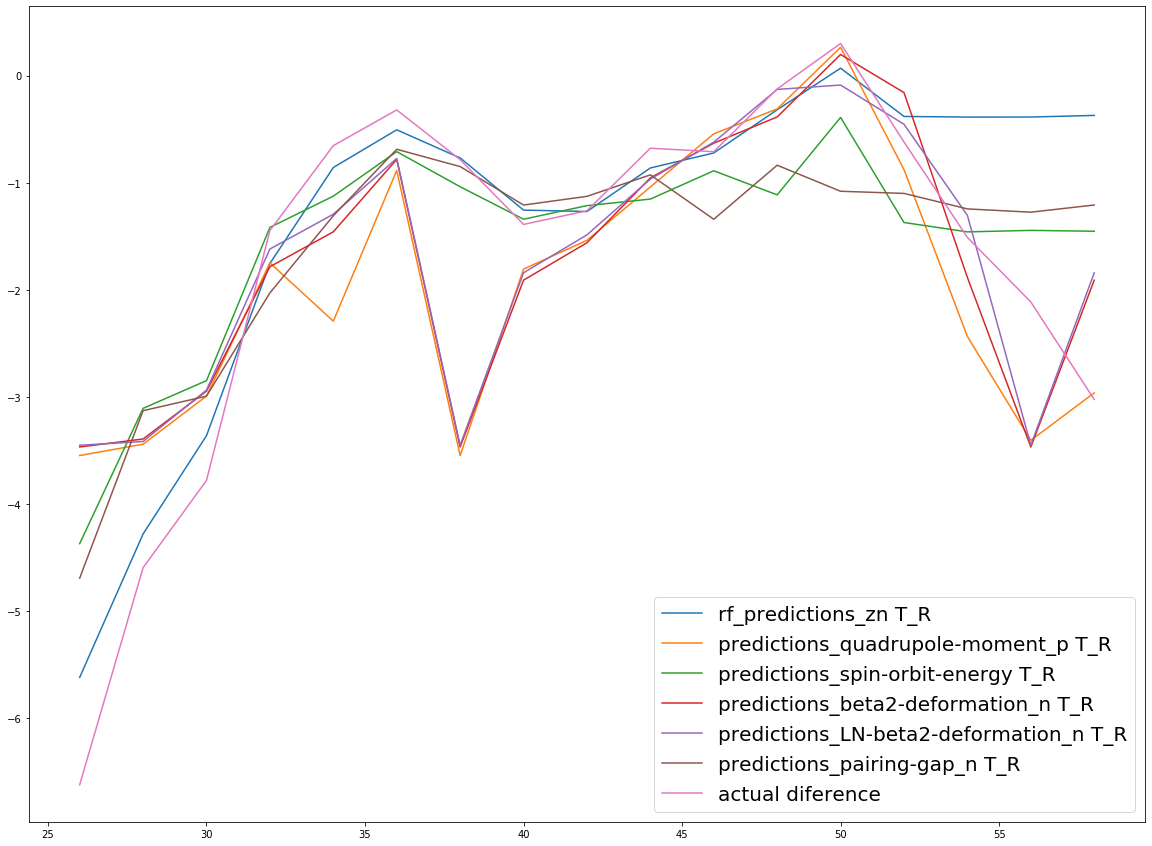

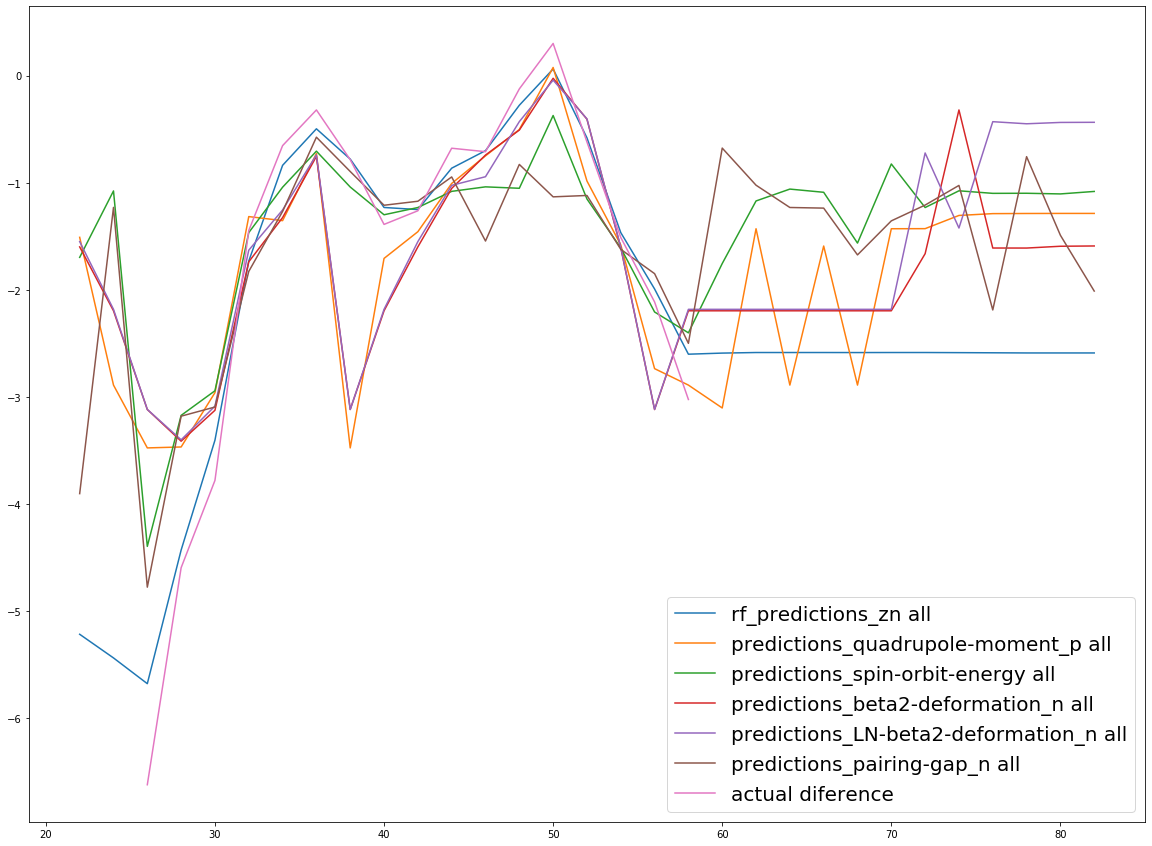

In [21]:
plot_element(32)
#diferent life
#zn only rf
#remove n and add new feature for rf
#then add a third to form every new combination
#

In [45]:
X_reduced = np.transpose(np.stack((reduced_match['proton_number'],
                                   reduced_match['neutron_number'],)))

X_match = np.transpose(np.stack((exp_match['proton_number'],
                                 exp_match['neutron_number'],)))


X_test = np.transpose(np.stack((test_match['proton_number'],
                                test_match['neutron_number'],)))

y_reduced = reduced_match['exp_theory_diff']
y_test    = test_match['exp_theory_diff']
y_match   = exp_match['exp_theory_diff']

print(np.shape(X_reduced))
print("using_reduced_and_test_match")
r_rf,r_predictions,t_predictions =using_reduced_and_test_match(X_reduced,X_test,y_reduced,y_test)
print('\n\n')
print('making_rf_predictions_for_match')
a_rf, a_pred  =making_rf_predictions_for_match(X_match, y_match)

(686, 2)
using_reduced_and_test_match
reduced set score:  0.971904696200722 

test set score:  0.7601474927942299
reduced error:     0.0756291089818085
test error:     0.9583691857251828



making_rf_predictions_for_match
feature importance:   [0.67782055 0.32217945]
train score:   0.9751408714198351
test score:    0.7602416423334742
train error:   0.07240514076733828
test error:    0.7714531064320167
all error:     0.2473705803690913


In [46]:
X_reduced = np.transpose(np.stack((reduced_match['proton_number'],
                           reduced_match['quadrupole-moment_p'],
                           reduced_match['spin-orbit-energy'],
                           reduced_match['beta2-deformation_p'])))

X_match = np.transpose(np.stack((exp_match['proton_number'],
                           exp_match['quadrupole-moment_p'],
                           exp_match['spin-orbit-energy'],
                           exp_match['beta2-deformation_p'])))


X_test = np.transpose(np.stack((test_match['proton_number'],
                           test_match['quadrupole-moment_p'],
                           test_match['spin-orbit-energy'],
                           test_match['beta2-deformation_p'])))

y_reduced = reduced_match['exp_theory_diff']
y_test    = test_match['exp_theory_diff']
y_match   = exp_match['exp_theory_diff']

print(np.shape(X_reduced))
print("using_reduced_and_test_match")
r_rf,r_predictions,t_predictions =using_reduced_and_test_match(X_reduced,X_test,y_reduced,y_test)
print('\n\n')
print('making_rf_predictions_for_match')
b_rf, b_pred  =making_rf_predictions_for_match(X_match, y_match)



(686, 4)
using_reduced_and_test_match
reduced set score:  0.9505650106085516 

test set score:  0.5829983049447633
reduced error:     0.13307292303763824
test error:     1.666197195901123



making_rf_predictions_for_match
feature importance:   [0.49015982 0.08219238 0.22957747 0.19807033]
train score:   0.9577646405432342
test score:    0.6191524412139415
train error:   0.12301546037564168
test error:    1.22542561252944
all error:     0.3989388395526692


In [47]:
X_reduced = np.transpose(np.stack((reduced_match['LN-beta2-deformation_n'],
                           reduced_match['quadrupole-moment_p'],
                           reduced_match['spin-orbit-energy'],
                           reduced_match['pairing-gap_n'],
                           reduced_match['LN-beta2-deformation_p'])))

X_match = np.transpose(np.stack((exp_match['LN-beta2-deformation_n'],
                           exp_match['quadrupole-moment_p'],
                           exp_match['spin-orbit-energy'],
                           exp_match['pairing-gap_n'],
                           exp_match['LN-beta2-deformation_p'])))


X_test =  np.transpose(np.stack((test_match['LN-beta2-deformation_n'],
                           test_match['quadrupole-moment_p'],
                           test_match['spin-orbit-energy'],
                           test_match['pairing-gap_n'],
                           test_match['LN-beta2-deformation_p'])))

y_reduced = reduced_match['exp_theory_diff']
y_test    = test_match['exp_theory_diff']
y_match   = exp_match['exp_theory_diff']

print(np.shape(X_reduced))
print("using_reduced_and_test_match")
r_rf,r_predictions,t_predictions =using_reduced_and_test_match(X_reduced,X_test,y_reduced,y_test)
print('\n\n')
print('making_rf_predictions_for_match')
c_rf, c_pred  =making_rf_predictions_for_match(X_match, y_match)



(686, 5)
using_reduced_and_test_match
reduced set score:  0.9406387114338726 

test set score:  0.5065584430803103
reduced error:     0.15979330191060606
test error:     1.971624931576754



making_rf_predictions_for_match
feature importance:   [0.08343862 0.26289704 0.4212525  0.11089816 0.12151368]
train score:   0.9472186480951613
test score:    0.4744856274201534
train error:   0.15373190585648883
test error:    1.6909095438719586
all error:     0.5384736895274155


In [48]:
X_reduced = np.transpose(np.stack((reduced_match['proton_number'],
                                   reduced_match['neutron_number'],
                                   reduced_match['LN-beta2-deformation_n'],
                           reduced_match['quadrupole-moment_p'],
                           reduced_match['spin-orbit-energy'],
                           reduced_match['pairing-gap_n'],
                           reduced_match['LN-beta2-deformation_p'])))

X_match = np.transpose(np.stack((exp_match['proton_number'],
                                 exp_match['neutron_number'],
                                 exp_match['LN-beta2-deformation_n'],
                           exp_match['quadrupole-moment_p'],
                           exp_match['spin-orbit-energy'],
                           exp_match['pairing-gap_n'],
                           exp_match['LN-beta2-deformation_p'])))


X_test =  np.transpose(np.stack((test_match['proton_number'],
                                 test_match['neutron_number'],
                                 test_match['LN-beta2-deformation_n'],
                                test_match['quadrupole-moment_p'],
                           test_match['spin-orbit-energy'],
                           test_match['pairing-gap_n'],
                           test_match['LN-beta2-deformation_p'])))

y_reduced = reduced_match['exp_theory_diff']
y_test    = test_match['exp_theory_diff']
y_match   = exp_match['exp_theory_diff']

print(np.shape(X_reduced))
print("using_reduced_and_test_match")
r_rf,r_predictions,t_predictions =using_reduced_and_test_match(X_reduced,X_test,y_reduced,y_test)
print('\n\n')
print('making_rf_predictions_for_match')
d_rf, d_pred  =making_rf_predictions_for_match(X_match, y_match)



(686, 7)
using_reduced_and_test_match
reduced set score:  0.960489177507118 

test set score:  0.6200567309051649
reduced error:     0.1063582839902176
test error:     1.5181243075845627



making_rf_predictions_for_match
feature importance:   [0.45984493 0.07593633 0.04691172 0.05702781 0.14877307 0.06359003
 0.14791611]
train score:   0.9660954642557851
test score:    0.6502666203926135
train error:   0.09875095481705115
test error:    1.125311771180667
all error:     0.35568992515253123


In [49]:
X_reduced = np.transpose(np.stack((reduced_match['spin-orbit-energy'],
                                   reduced_match['LN-beta2-deformation_p'],)))

X_match = np.transpose(np.stack((exp_match['spin-orbit-energy'],
                                 exp_match['LN-beta2-deformation_p'],)))


X_test = np.transpose(np.stack((test_match['spin-orbit-energy'],
                                test_match['LN-beta2-deformation_p'],)))

y_reduced = reduced_match['exp_theory_diff']
y_test    = test_match['exp_theory_diff']
y_match   = exp_match['exp_theory_diff']

print(np.shape(X_reduced))
print("using_reduced_and_test_match")
r_rf,r_predictions,t_predictions =using_reduced_and_test_match(X_reduced,X_test,y_reduced,y_test)
print('\n\n')
print('making_rf_predictions_for_match')
e_rf, e_pred  =making_rf_predictions_for_match(X_match, y_match)

(686, 2)
using_reduced_and_test_match
reduced set score:  0.9261105752298797 

test set score:  0.42483116779715596
reduced error:     0.19890126116686313
test error:     2.2981793761273765



making_rf_predictions_for_match
feature importance:   [0.60226754 0.39773246]
train score:   0.9353077387060976
test score:    0.37951265321657124
train error:   0.18842383273562685
test error:    1.9964972059227089
all error:     0.6409683906346054


In [56]:
names=['quadrupole-moment_p',
'spin-orbit-energy',
'beta2-deformation_n',
'LN-beta2-deformation_n',
'pairing-gap_n',
'beta2-deformation_p',]

for i in names:
    X_reduced = np.transpose(np.stack((reduced_match['proton_number'],
                                   reduced_match['neutron_number'],
                                   reduced_match[i])))

    X_match = np.transpose(np.stack((exp_match['proton_number'],
                                     exp_match['neutron_number'],
                                    exp_match[i])))


    X_test = np.transpose(np.stack((test_match['proton_number'],
                                    test_match['neutron_number'],
                                    test_match[i])))

    y_reduced = reduced_match['exp_theory_diff']
    y_test    = test_match['exp_theory_diff']
    y_match   = exp_match['exp_theory_diff']
    
    print('z, n, ', i)
    getting_feature_importance(X_match, y_match)
    
    
    

z, n,  quadrupole-moment_p
feature importance:   [0.53368357 0.20810413 0.2582123 ]
score importance:   0.9710743531615044
z, n,  spin-orbit-energy
feature importance:   [0.58055633 0.18078697 0.2386567 ]
score importance:   0.9654124389146527
z, n,  beta2-deformation_n
feature importance:   [0.53593593 0.20417178 0.25989229]
score importance:   0.9708050021645849
z, n,  LN-beta2-deformation_n
feature importance:   [0.53751024 0.20500102 0.25748874]
score importance:   0.9704745699037285
z, n,  pairing-gap_n
feature importance:   [0.6168939  0.20588825 0.17721785]
score importance:   0.9704952483751645
z, n,  beta2-deformation_p
feature importance:   [0.52787186 0.20082108 0.27130706]
score importance:   0.9706209816934289


In [62]:

for i in names:
    X_reduced = np.transpose(np.stack((reduced_match['proton_number'],
                                   reduced_match['neutron_number'],
                                   reduced_match[i])))

    X_match = np.transpose(np.stack((exp_match['proton_number'],
                                     exp_match['neutron_number'],
                                    exp_match[i])))


    X_test = np.transpose(np.stack((test_match['proton_number'],
                                    test_match['neutron_number'],
                                    test_match[i])))

    y_reduced = reduced_match['exp_theory_diff']
    y_test    = test_match['exp_theory_diff']
    y_match   = exp_match['exp_theory_diff']
    
    print('\n\n','z, n, ', i)
    
    using_reduced_and_test_match(X_reduced, X_test, y_reduced, y_test)
    
    
    #GET FIGURES
    #zn,PREDICTIONS IN REDUCED, TEST AND ALL
    #ISOTOPE AS A FUNCTION OF N
    #zn OLNLY AND THEN ADD ONE FEATURE EACH 
    # AND FOR SEPARATION ENERGY WITH RF ADDED



 z, n,  quadrupole-moment_p
feature importance:   [0.47775225 0.24730699 0.27494076]
test score reduction -0.2963587789787925
reduced_set_score:  0.9654828794168595
test_set_score:  0.669124100438067


 z, n,  spin-orbit-energy
feature importance:   [0.53735245 0.24537838 0.21726916]
test score reduction -0.2847180555806669
reduced_set_score:  0.9607363608734517
test_set_score:  0.6760183052927848


 z, n,  beta2-deformation_n
feature importance:   [0.4890252  0.24665806 0.26431674]
test score reduction -0.3183450254560274
reduced_set_score:  0.9635211790363705
test_set_score:  0.6451761535803431


 z, n,  LN-beta2-deformation_n
feature importance:   [0.48989209 0.2451625  0.26494542]
test score reduction -0.3282877668648059
reduced_set_score:  0.9633101445633632
test_set_score:  0.6350223776985573


 z, n,  pairing-gap_n
feature importance:   [0.5390342  0.26239355 0.19857225]
test score reduction -0.28435093000065326
reduced_set_score:  0.965596606745811
test_set_score:  0.68124567

In [67]:
for i in names:
    for j in names:
        if (i!=j):
            X_reduced = np.transpose(np.stack((reduced_match[i], reduced_match[j])))

            X_match = np.transpose(np.stack((exp_match[i],exp_match[j])))


            X_test = np.transpose(np.stack((test_match[i],test_match[j])))

            y_reduced = reduced_match['exp_theory_diff']
            y_test    = test_match['exp_theory_diff']
            y_match   = exp_match['exp_theory_diff']

            print('\n\n',i,'  ', j)
            getting_feature_importance(X_match, y_match)
    
            #using_reduced_and_test_match(X_reduced, X_test, y_reduced, y_test)
            #GET TEST SCORE AND TRAINED SCOREJ
            #JUST USE ONE FEATURE CATEGORY 



 quadrupole-moment_p    spin-orbit-energy
feature importance:   [0.53364237 0.46635763]
score importance:   0.9354407825095559


 quadrupole-moment_p    beta2-deformation_n
feature importance:   [0.74649103 0.25350897]
score importance:   0.8156441419918387


 quadrupole-moment_p    LN-beta2-deformation_n
feature importance:   [0.74068435 0.25931565]
score importance:   0.8188388795694924


 quadrupole-moment_p    pairing-gap_n
feature importance:   [0.67047458 0.32952542]
score importance:   0.9200548963000964


 quadrupole-moment_p    beta2-deformation_p
feature importance:   [0.75596482 0.24403518]
score importance:   0.8169057473880227


 spin-orbit-energy    quadrupole-moment_p
feature importance:   [0.46639741 0.53360259]
score importance:   0.9354619185179592


 spin-orbit-energy    beta2-deformation_n
feature importance:   [0.55922391 0.44077609]
score importance:   0.9316521438803875


 spin-orbit-energy    LN-beta2-deformation_n
feature importance:   [0.56139942 0.43860058]

In [68]:
exp_match['rf_predictions']    =preds_match
theory_only['rf_predictions']  =theory_only_predictions


NameError: name 'preds_match' is not defined

In [ ]:
rf_1.feature_importances_
